<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab05_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5, solutions
On "Why do we need both validation and test sets"?

See the [`lab05_debrief.md`](lab05_debrief.md) file as well.

Stephen Becker, SciML class

Note: these solutions did not get around to doing part 4 successfully

In [193]:
import numpy as np

Two-sided [Hoeffding inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality#Special_Case:_Bernoulli_RVs) for Bernoulli r.v.
$$
\mathbb{P}\left[\left| \frac{1}{n}S_n - \mu  \right| \ge t\right] \le 2 \exp\left( -2nt^2\right)
$$
or equivalently
$$
\mathbb{P}\left[ \left| \frac{1}{n}S_n - \mu  \right| < t\right] > 1- 2 \exp\left( -2nt^2\right)
$$
where $S_n=X_1+X_2+\ldots+X_n$ is the sum of $n$ **independent** Bernoulli random variables.  

## Part 1
Let $\mu$ be the true risk of a binary classifier $f$ (using the 0-1 loss $\ell$), and suppose we have $n$ independent samples (that are also independent of $f$), and let $\frac{1}{n}S_n$ be the empirical risk (still using the 0-1 loss) on these samples.  (Think of these as validation or testing samples)

**Q**: If we want to estimate $\mu$ to an accuracy of $\pm t$, with a confidence of $p=1-\alpha$, how many samples $n$ do we need? Do this for $t=0.001, 0.01, 0.02$ and $0.05$, and for $\alpha$ being $10^{-1},10^{-2},10^{-3},10^{-4},10^{-5}$. Make a table of the resulting $n$ values.

Comment on whether $p$ or $t$ has a "bigger effect".

**A**: set $\alpha = 2 \exp\left( -2nt^2\right)$, plug in $t$, and solve for $n$, so
$$
-2nt^2 = \ln\left( \frac{\alpha}{2} \right),\quad\text{i.e.},\quad
n = \frac{ \ln(2/\alpha) }{2t^2}
$$

|  $t$\ $\alpha$       |     1e-05|     1e-04|     1e-03|     1e-02|     1e-01|
| ---:  |  ---:    |  ---:    |  ---:    |  ---:    |  ---:    |
|0.001	|   6103036|   4951743|   3800451|   2649158|   1497866|
|0.010	|     61030|     49517|     38004|     26491|     14978|
|0.020	|     15257|     12379|      9501|      6622|      3744|
|0.050	|      2441|      1980|      1520|      1059|       599|

We note that the dependence on $p$ (i.e., $\alpha$) is very mild, because of the exponential. On the other hand, the dependence on the error bars $t$ is substantial. So it's very hard to get a very precise answer. But if we want a loose answer, but to be very certain about it, that's no problem.

That is to say, if we take $1000$ samples in our test data, we can be $99\%$ or more confident that our true risk is within $5\%$ of our sample risk.

In [200]:
sep=""  # for printing to screen
# sep="|" # for copying to markdown


aList = np.logspace(-5,-1,5)
print(end=sep)
print("        ",end=sep)
for alpha in aList:
    print(f"{alpha:10.0e}",end=sep)
print(flush=True)
for t in [0.001, 0.01, 0.02, 0.05]:
    nValues = []
    print(end=sep)
    print(f"{t:.3f}",end="\t")
    print(end=sep)
    for alpha in aList:
        n = np.log(2/alpha)/(2*(t**2))
        print(f"{int(n):-10d}",end=sep)
    print(flush=True)

# Or viewed another way, if we fix n=1000, and want to be 99% certain,
#   what is the value of t?
t_1000 = np.sqrt( np.log(2/.01) / (2*1000 ))
print(f'For n=1000 and 99\% certainty, t is {t_1000:.3f}')

             1e-05     1e-04     1e-03     1e-02     1e-01
0.001	   6103036   4951743   3800451   2649158   1497866
0.010	     61030     49517     38004     26491     14978
0.020	     15257     12379      9501      6622      3744
0.050	      2441      1980      1520      1059       599
For n=1000 and 99\% certainty, t is 0.051


## Utility code (for parts 2--4)

In [194]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [314]:
torch.manual_seed(101)
d = 1  # dimension

def get_feature_samples(n):
    return torch.rand( (n,d) )-0.5 # uniform in [-.5,5]^d

def f(x):
    """ the *true* function that we're trying to learn
    Should be 0 and 1 outputs
    """
    y = (torch.sign( torch.sin( 15*x + 50*torch.sign(x)*x**2 ) ) + 1 )/2
    return y.long().flatten() # the datatype torch expects for classification

# if d == 1:
#     # Easy to plot
#     X_plot = torch.linspace(-.5,.5,300)
#     y_plot = f(X_plot)
#     plt.plot( X_plot, y_plot )
#     plt.show()


n_test      = int(1e5) # Pick enough to make this the "truth"
X_test      = get_feature_samples(n_test)
y_test      = f(X_test) # can use torch.vmap if needed
testset     = torch.utils.data.TensorDataset(X_test,  y_test)
testloader  = torch.utils.data.DataLoader(testset,batch_size=1000)

vals,bins   = torch.histogram(y_test.float(),bins=2)
print(vals/n_test) # check if the data is approximately well-balanced
# print(bins)

act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}
class Net( nn.Module ):
    """ A simple fully-connected neural net, all hidden layers the same size
    This does binary classification by default (outputDim=2), setup for cross-entropy loss
    """
    def __init__(self, nHiddenLayers=5, width=100, activation = None,
                 outputDim=2, inputDim = 1, act_fn_name="relu"  ):
        super().__init__()
        if activation is None:
            activation = act_fn_by_name[act_fn_name]()
        # Construct a net as instructed (all hidden layers of the same size)
        self.net = []
        fc = nn.Linear(inputDim, width)
        # nn.init.xavier_uniform_(fc.weight)
        self.net.append(fc)
        self.net.append( activation )
        for i in range(nHiddenLayers):
            self.net.append(nn.Linear(width, width))
            self.net.append( activation )
        self.net.append(nn.Linear(width, outputDim))
        self.net = nn.Sequential(*self.net)
    def forward(self, x):
        return self.net(x)

def empiricalRisk( model, dataloader ):
    """ We need a dataloader, not a dataset
    (otherwise the size of the tensor isn't correct)
    Assumes the true labels are [0,1,...,outputdim-1]

    "Risk" is a slight misnomer, as usually a smaller risk is better.
    This is actually the classification accuracy, between 0 and 1,
    and higher is better
    """
    model.eval()
    with torch.no_grad():
        total   = 0
        correct = 0
        for data in dataloader:
            inputs, trueLabels = data
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            total   += trueLabels.size(0)
            # Careful: if predicted is of size (batchSize,1)
            #   and trueLabels are of size (batchSize,) then using "=="
            #   will implicitly broadcast them to the wrong size!
            correct += (predicted.ravel() == trueLabels.ravel() ).sum().item()
            # We did .sum() in case batch size > 1
    return correct/total

def train_model( trainloader, optimizer, epochs = 30, criterion = nn.CrossEntropyLoss(), verbose=False  ):
    """
    You don't explicitly pass in the model, but that's implicit in the optimizer
    """
    for t in range(epochs):
        runningLoss = 0.
        for i,data in enumerate(trainloader):
            inputs, trueLabels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs,trueLabels.flatten() )
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        if verbose and ( t < 10 or t % 10 == 9 ):
            print(f'Epoch {t+1:3d}, training (surrogate) loss is {runningLoss/i:.2f}')

tensor([0.5028, 0.4972])


## Part 2: for a fixed model, look at validation risk

Fix some classifier $h$ (i.e., model), and for each data point $(X_i,y_i)$ for $i=1,\ldots,n_\text{validation}$, we set the random variable
$$
Z_i = \begin{cases} 1 & y_i = h(X_i) \\ 0 & y_i \neq h(X_i)\end{cases}
$$
so $S_n$ represents the **accuracy** (i.e., empirical risk, if we use the 0-1 loss) of our model $h$ on this data.

We'll find $\mu$ by evaluating accuracy on a huge number of testing points.

Then, for many **experiments**, draw a new validation set (of size $n_\text{validation}=1000$) and we compare that estimate $S_n$ with $\mu$.  We do many experiments so that we can estimate the probability of $|S_n - \mu| > t$  (we can choose $t$ *after* we run the experiments)


In [315]:
model = Net(nHiddenLayers=3, width=20 )
trueRisk    = empiricalRisk(model, testloader)
# How well does an untrained model do?
#   Note: you may need to run this a few times (each time will give different random initializations)
#       in order to get a model that has an interesting risk (sometimes you get 0%...)
print(f"True risk: {trueRisk}")

True risk: 0.49724


In [233]:
n_valid     = int(1e3)

nExperiments = 1000
risks        = []
for i in range(nExperiments):
    X_valid     = get_feature_samples(n_valid)
    y_valid     = f(X_valid)
    validset    = torch.utils.data.TensorDataset(X_valid, y_valid)
    validloader = torch.utils.data.DataLoader(validset,batch_size=1000)
    risks.append( empiricalRisk(model, validloader) )

risks = np.array(risks)

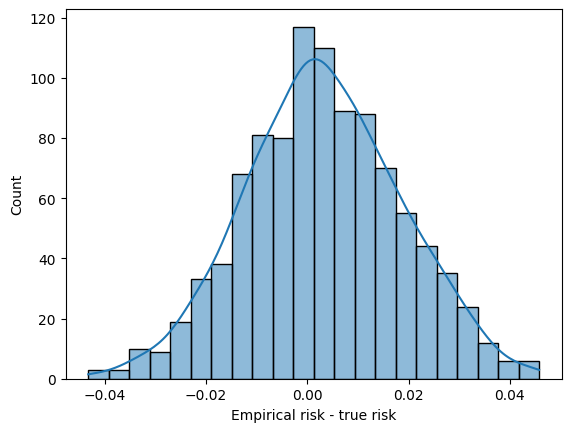

In [238]:
# plt.hist(risks - trueRisk)
# plt.xlabel("Empirical risk - true risk")
# plt.show()

# Or, a fancier historgram
import seaborn as sns
fig, ax = plt.subplots()
sns.histplot(risks - trueRisk, ax=ax,kde=True)
ax.set_xlabel("Empirical risk - true risk")
plt.show()

In [239]:
# and let's look at the .5% and 99.5% percent quantiles
tList = np.quantile( risks - trueRisk, [0.005, 0.995] )
print(tList)
t = np.linalg.norm(tList,ord=np.Inf)
print(t)

[-0.035245  0.04177 ]
0.04177000000000001


If the $.5\%$ and $99.5\%$ quantiles are, say, `[-0.038  0.041]`, this means that $99\%$ of the data is within $t=0.41$ of the true mean

In [240]:
# What do we expect for t, from Hoeffding's inequality?  If we're asking about p=.99, then...
print(f'Theory predicts 99% confidence if t >= {t_1000:.4f}. Empirical value: {t:.4f}')

Theory predicts 99\% confidence if t >= 0.0515. Empirical value: 0.0418


## Part 3: choose the best from among many models
Now, fix a given validation set, but we'll do many experiments with sets of models.

That is, for a set of 10 models, we'll choose the best model (in terms of accuracy; higher is better)

In [242]:
# Use a single validation set...
X_valid     = get_feature_samples(n_valid)
y_valid     = f(X_valid)
validset    = torch.utils.data.TensorDataset(X_valid, y_valid)
validloader = torch.utils.data.DataLoader(validset,batch_size=1000)

# Rather than train, we can just initialize with random weights
# This *should* be automatic if we ask for a new Net() object
#   since by default PyTorch does random initialization.
# Be careful!  There's a subtlety: since our data is not perfectly balanced,
#   if we initialize in such a way so that the model always predicts all 1s, or all 0s,
#   that is often the best. This effect will go away with training,
#   or we could have a perfectly balanced dataset...

# We can also initialize ourself:
# From: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/03-initialization-and-optimization.html
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / np.sqrt(param.shape[1]))
model = Net(nHiddenLayers=3,width=20 )


nExperiments = 100
nModels      = 10
errors       = []
trueRisks    = []
for i in range(nExperiments):

    bestRisk = -1
    for j in range(nModels):
        # Choose random model
        #model = Net(nHiddenLayers=3,width=20 )
        equal_var_init(model)
        # For now, we're lazy and we won't train (but should still see the effect)
        risk =  empiricalRisk(model, validloader)
        if risk > bestRisk:
            # "risk" is really accuracy, so higher is better
            #   We'll naturally work with the model that did the best:
            bestRisk = risk
            mu       = empiricalRisk(model, testloader)  # estimate with a lot of data
            #print(f'Estimated risk {bestRisk:.3f}, true risk for this model is {mu:.3f}')

    errors.append( bestRisk - mu)
    trueRisks.append(mu) # should be better than 50-50

errors = np.array(errors)
trueRisks = np.array(trueRisks)

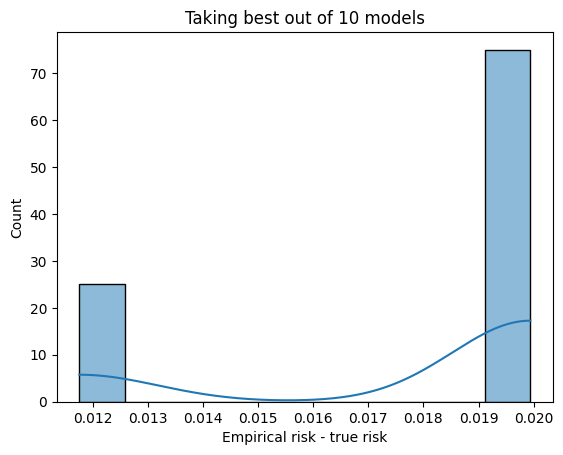

In [244]:
import seaborn as sns
fig, ax = plt.subplots()
sns.histplot(errors, ax=ax,kde=True)
ax.set_xlabel("Empirical risk - true risk")
plt.title('Taking best out of 10 models')
plt.show()

In [257]:
alpha = 0.05
t_theory = np.sqrt( np.log(2/alpha) / (2*n_valid ))

tList = np.quantile( errors, [alpha/2, 1-alpha/2] )
t = np.linalg.norm(tList,ord=np.Inf)

print(f'Theory predicts {(1-alpha)*100:.1f}% confidence if t >= {t_theory:.4f}. Empirical value: {t:.4f}')
# As long as t_theory > t_empirical, we're OK
#   If not, then theory is wrong (or its assumptions are wrong!)

Theory predicts 95.0% confidence if t >= 0.0429. Empirical value: 0.0312


In our case, we don't violate the theory bounds *per se*, but we certainly don't have a nice central limit theorem style result. The histogram is clearly biased. Our estimate of the accuracy is always an overestimate!!

## Part 4: training and choosing best hyperparameters
Something isn't right... there's a bug in the training script I think.

In [294]:
#!pip install pytorch-lightning

In [320]:
import pytorch_lightning as pl
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}
class MyModule(pl.LightningModule):
    def __init__(self, model_hparams=None, optimizer_name="SGD", optimizer_hparams=None):
        """
        Code modified from https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/04-inception-resnet-densenet.html
        This expects modules of the following names:
            __init__, forward, configure_optimizers, training_step, validation_step, test_step
        """
        super().__init__()
        self.save_hyperparameters() # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.model = Net(**model_hparams)  # the Net() we defined earlier...
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1), dtype=torch.float32)

    def forward(self, X):
        # Forward function that is run when visualizing the graph
        return self.model(X)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/abs/1711.05101)
            optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss =  self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=True, on_epoch=False,prog_bar=True) # we're (hopefully) indirectly optimizing this
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (labels == preds.argmax(dim=-1)).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        acc = (labels == preds.argmax(dim=-1)).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [325]:
n_train     = int(1e3) # not too large, in order to keep this fast
X_train     = get_feature_samples(n_train)
y_train     = f(X_train)
trainset    = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
criterion   = nn.CrossEntropyLoss()

# Use a single validation set...
X_valid     = get_feature_samples(n_valid)
y_valid     = f(X_valid)
validset    = torch.utils.data.TensorDataset(X_valid, y_valid)
validloader = torch.utils.data.DataLoader(validset,batch_size=1000)

model = MyModule(
    model_hparams={"act_fn_name": "tanh"},
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-2, "weight_decay": 1e-4} )
risk =  empiricalRisk(model, validloader)
print(f'First run: validation error is {risk:.3f} *before* training')

trainer = pl.Trainer(
        logger=False,  accelerator="auto",
        max_epochs=50, profiler=None )

trainer.fit(model, trainloader, validloader)
risk =  empiricalRisk(model, validloader)
print(f'First run: validation error is {risk:.3f} *after* training')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | Mode | In sizes | Out sizes
-------------------------------------------------------------------------------
0 | model       | Net              | 50.9 K | eval | [1]      | [2]      
1 | loss_module | CrossEntropyLoss | 0      | eval | ?        | ?        
-------------------------------------------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
0         Modules in train mode
11        Modules in eval mode


First run: validation error is 0.529 *before* training


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


First run: validation error is 0.471 *after* training


First run: validation error is 0.740 *after* training


In [292]:
# Can we train this model? Let's make sure
n_train     = int(1e3) # not too large, in order to keep this fast
X_train     = get_feature_samples(n_train)
y_train     = f(X_train)
trainset    = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
criterion   = nn.CrossEntropyLoss()

# Use a single validation set...
X_valid     = get_feature_samples(n_valid)
y_valid     = f(X_valid)
validset    = torch.utils.data.TensorDataset(X_valid, y_valid)
validloader = torch.utils.data.DataLoader(validset,batch_size=1000)

model = Net(nHiddenLayers=5, width=30 )
risk =  empiricalRisk(model, validloader)
print(f'First run: validation error is {risk:.3f} *before* training')
optimizer     = torch.optim.SGD(model.parameters(),lr=1e-1)
model.train()
train_model( trainloader, optimizer, epochs=1000, verbose=True )
risk =  empiricalRisk(model, validloader)
print(f'First run: validation error is {risk:.3f} *after* training')

First run: validation error is 0.506 *before* training
Epoch   1, training (surrogate) loss is 0.73
Epoch   2, training (surrogate) loss is 0.73
Epoch   3, training (surrogate) loss is 0.73
Epoch   4, training (surrogate) loss is 0.73
Epoch   5, training (surrogate) loss is 0.73
Epoch   6, training (surrogate) loss is 0.73
Epoch   7, training (surrogate) loss is 0.73
Epoch   8, training (surrogate) loss is 0.73
Epoch   9, training (surrogate) loss is 0.73
Epoch  10, training (surrogate) loss is 0.73
Epoch  20, training (surrogate) loss is 0.73
Epoch  30, training (surrogate) loss is 0.73
Epoch  40, training (surrogate) loss is 0.73
Epoch  50, training (surrogate) loss is 0.73
Epoch  60, training (surrogate) loss is 0.73
Epoch  70, training (surrogate) loss is 0.73
Epoch  80, training (surrogate) loss is 0.73
Epoch  90, training (surrogate) loss is 0.73
Epoch 100, training (surrogate) loss is 0.73
Epoch 110, training (surrogate) loss is 0.73
Epoch 120, training (surrogate) loss is 0.73


KeyboardInterrupt: 

In [286]:
n_train     = int(1e3) # not too large, in order to keep this fast
X_train     = get_feature_samples(n_train)
y_train     = f(X_train)
trainset    = torch.utils.data.TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=250, shuffle=True)
criterion   = nn.CrossEntropyLoss()

# Use a single validation set...
X_valid     = get_feature_samples(n_valid)
y_valid     = f(X_valid)
validset    = torch.utils.data.TensorDataset(X_valid, y_valid)
validloader = torch.utils.data.DataLoader(validset,batch_size=1000)

# Hyperparameters:
nHiddenLayers = 5
width         = 30
learning_rate = 1e-2
epochs        = 120  # let's make it fast!

nExperiments = 50
nModels      = 5
errors       = []
trueRisks    = []
for i in range(nExperiments):
    print(f'Experiment {i+1:3d} of {nExperiments}')
    bestRisk = -1
    for j in range(nModels):
        # Choose hyperparameters randomly
        # ... or don't. We can just rely on the random initialization
        # nHiddenLayers   = torch.randint(1,10,(1,))
        # width           = torch.randint(10,200,(1,))
        # log_learning_rate = torch.rand((1,))
        # learning_rate   = 10**( -3 + log_learning_rate )
        # epochs          = torch.randint(10,100,(1,) )

        model = Net(nHiddenLayers=nHiddenLayers, width=width )
        verbose = ( i==0 and j==0 )
        if verbose:
            risk =  empiricalRisk(model, validloader)
            print(f'First run: validation error is {risk:.3f} *before* training')
        optimizer     = torch.optim.SGD(model.parameters(),lr=learning_rate)

        # Train it
        model.train()
        train_model( trainloader, optimizer, epochs=epochs, verbose=False )

        # For now, we're lazy and we won't train (but should still see the effect)
        risk =  empiricalRisk(model, validloader)
        if verbose:
            # Sanity check
            print(f'First run: validation error is {risk:.3f} *after* training')
        if risk > bestRisk:
            # "risk" is really accuracy, so higher is better
            #   We'll naturally work with the model that did the best:
            bestRisk = risk
            mu       = empiricalRisk(model, testloader)  # estimate with a lot of data
            #print(f'Estimated risk {bestRisk:.3f}, true risk for this model is {mu:.3f}')

    errors.append( bestRisk - mu)
    trueRisks.append(mu) # should be better than 50-50

errors = np.array(errors)
trueRisks = np.array(trueRisks)

Experiment   1 of 50
First run: validation error is 0.500 *before* training
First run: validation error is 0.500 *after* training


KeyboardInterrupt: 

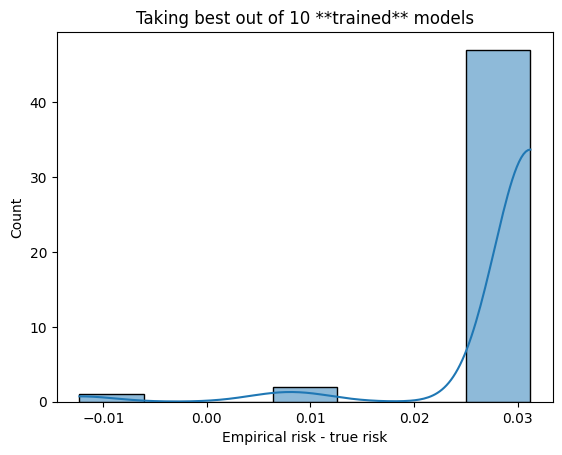

In [256]:
import seaborn as sns
fig, ax = plt.subplots()
sns.histplot(errors, ax=ax,kde=True)
ax.set_xlabel("Empirical risk - true risk")
plt.title('Taking best out of 10 **trained** models')
plt.show()

In [261]:
alpha = 0.3
t_theory = np.sqrt( np.log(2/alpha) / (2*n_valid ))

tList = np.quantile( errors, [alpha/2, 1-alpha/2] )
t = np.linalg.norm(tList,ord=np.Inf)

print(f'Theory predicts {(1-alpha)*100:.1f}% confidence if t >= {t_theory:.4f}. Empirical value: {t:.4f}')
# As long as t_theory > t_empirical, we're OK
#   If not, then theory is wrong (or its assumptions are wrong!)

Theory predicts 70.0% confidence if t >= 0.0308. Empirical value: 0.0312
